In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import os

#import the Cross sections file 
openmc.config['cross_sections'] = "/home/f_z/endfb-vii.1-hdf5/cross_sections.xml"

In [2]:
#Usefull functions for the simulation 


def cleaner(directory="."):
    """
    Removes all files in the specified directory whose names 
    contain 'statepoint' or 'summary'.

    Parameters:
    - directory (str): The folder where files should be deleted (default: current directory).
    """
    files_deleted = 0
    for filename in os.listdir(directory):  # Loop through files in directory
        if "statepoint" in filename or "summary" in filename:
            file_path = os.path.join(directory, filename)  # Full file path
            try:
                os.remove(file_path)  # Delete file
                files_deleted += 1
                print(f" Deleted: {filename}")
            except Exception as e:
                print(f" Error deleting {filename}: {e}")
    if files_deleted == 0:
         print("No matching files found in the directory.")

def check_enrichment(enrichment, enrichment_pos):
    '''
    It's a function to control the avg value of the enrichment of the assembly.
    -Enrichment is an np.array, it gives the values of enrichment used 
    -enrichment_pos gives a np.array, it reports the number of assembly per enrichment
    '''
    avg_enrichment=0.
    total_pins=264
    for i in range (len(enrichment)):
        avg_enrichment=avg_enrichment+enrichment[i]*enrichment_pos[i]/264
    return avg_enrichment
    
    """
    Run OpenMC simulations with different batch sizes to determine 
    optimal convergence for k-eff.

    Parameters:
    - name (str): A label for the case to differentiate runs.
    - N (int): Number of test cases (batch values).
    - batch_range (tuple): (min_batches, max_batches) to test.
    - inactive (int), the percentage of inactive batches
    - source, the one that i defined in the simulation settings cell.
    - particles (int): Number of particles per batch.
    
    Returns:
    - Dictionary with batch sizes, keff values, and relative errors.
    """

def optimize_batches(name, N, batch_range, inactive, source, particles):
    
    cleaner()
    
    batch_sizes = np.linspace(batch_range[0], batch_range[1], N, dtype=int)
    
    keffs = []
    relative_errors = []
    keff_stddev = []
    
    print(f"\n Running batch optimization for {name}...")

    for n_batches in batch_sizes:
        
        #rename the summary file to not interrupt the loop
        summary_new_name = f"summary_{n_batches}.h5"
        !mv summary.h5 {summary_new_name}
       
        n_inactive = (inactive*n_batches)//100  # inactive% of batches 
        
        settings = openmc.Settings()
        settings.batches = n_batches
        settings.inactive = n_inactive
        settings.particles = particles
        settings.source = source
        settings.export_to_xml()

        openmc.run()

        #extract keff from the latest statepoint file
        sp = openmc.StatePoint(f"statepoint.{n_batches}.h5")
        
        #storing values
        
        keff_stddev.append(sp.keff.std_dev)   #mean and standard deviation of keff
        keffs.append(sp.keff.nominal_value)
        
        #compute relative error correctly
        
        keff_relative_error = np.array(keff_stddev) / np.array(keffs)
        relative_errors.append(keff_relative_error)

       
    #plot results
    fig, ax1 = plt.subplots(figsize=(8,6))

    # Plot keff values
    ax1.errorbar(batch_sizes, keffs, keff_stddev, fmt='o-', color='blue', label="keff")
    ax1.set_xlabel("Total Batches")
    ax1.set_ylabel("keff", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    # Plot relative error on second y-axis
    
    ax2 = ax1.twinx()
    ax2.plot(batch_sizes, keff_relative_error, 's-', color="red", label="Relative Error")
    ax2.set_ylabel("Relative Error", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title(f"Sensitivity analysis({name})")
    plt.grid()
    plt.show()

    # Return results for further analysis
    #return {"batches": batch_sizes, "keff": keff_values, "errors": keff_errors, "relative_errors": relative_errors}


In [3]:
#ZIRCALOY
#(from Input Correlations for Irradiation Creep of FeCrAl and SiC Based...)
#and Analysis of Options andExperimental Examination of Fuels for Water Cooled Reactors with Increased Accident Tolerance (ACTOF)

###Uranium###
uo2=openmc.Material(material_id=1)
uo2.add_element('U',1,enrichment=5.0) 
uo2.add_element('O',2)
uo2.set_density('g/cm3',10.3)

###Coolant###
water=openmc.Material(material_id=2)
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3',0.650)

###Assembly###

#gap and plenum
helium=openmc.Material(material_id=3)
helium.add_element('He',1)
helium.set_density('g/cm3',0.0043)


###Cladding###
zircaloy=openmc.Material(material_id=4)
zircaloy.add_element('Zr',0.9843,'wo')
zircaloy.add_element('Sn',0.0120,'wo')
zircaloy.add_element('Fe',0.0021,'wo')
zircaloy.add_element('Cr',0.0012,'wo')
zircaloy.add_element('O',0.0003,'wo')
zircaloy.set_density('g/cm3',6.57)

#plugs and thimbles
steel= openmc.Material(material_id=5)
steel.add_element('C',0.0005,'wo')
steel.add_element('Ti',0.005,'wo')
steel.add_element('Cr',0.1625,'wo')
steel.add_element('Mn',0.02,'wo')
steel.add_element('Fe',0.65,'wo')
steel.add_element('Ni',0.14,'wo')
steel.add_element('Mo',0.022,'wo')
steel.set_density('g/cm3',7.55)

material_colors = {
    uo2: "orange", 
    steel: "darkgray",         
    zircaloy: "silver",         
    helium: "green", 
    water: "purple",        
}

materials=openmc.Materials([uo2,helium,water,zircaloy,steel])
materials.export_to_xml()
#-rodheight/2(b_bottom_plug)#bottom_plug_pos#pellet_stack#bottom_plenum_pos#top_plenum_pos(t_bottom_plug)#rodheight/2(t_top_plug)#
#reflective measn that we don't have leakages

###Geometry###

rod_pitch=1.26
frod_height=385.866  

r_p=0.857/2
r_g=r_p+0.016
r_c=r_g+0.0570 

#Fuel Pin: lateral surfaces, infinite cylinders centered in z axis with radius in cm
s_pellet=openmc.ZCylinder(0,0,r_p)
s_gap=openmc.ZCylinder(0,0,r_g)
s_clad=openmc.ZCylinder(0,0,r_c)

#Top and bottom surface
s_top=openmc.ZPlane(frod_height/2., boundary_type='vacuum') 
s_bottom=openmc.ZPlane(-frod_height/2, boundary_type='vacuum') 

#Planes internal to the pins
bottom_plug_pos=-frod_height/2+1.465
bottom_plenum_pos=frod_height/2-16.457-1.468
top_plenum_pos=frod_height/2-1.468

s_bottom_plenum= openmc.ZPlane(bottom_plenum_pos) 
s_top_plenum= openmc.ZPlane(top_plenum_pos)
s_b_top_end_plug= openmc.ZPlane(bottom_plug_pos) #surface between bottom plug and fuel pellet stack

square_cell = openmc.model.RectangularPrism(rod_pitch,rod_pitch)

###Cell construction ###

c_pellet=openmc.Cell(name="Pellet")
c_pellet.region=+s_b_top_end_plug & -s_bottom_plenum & -s_pellet 
c_pellet.fill=uo2  

c_gap=openmc.Cell(name="Gap") #gas in the gap along the fuel stack
c_gap.region=+s_pellet & +s_b_top_end_plug & -s_bottom_plenum & -s_gap 
c_gap.fill=helium

#gas plenum
c_gas= openmc.Cell(name='gas plenum')
c_gas.region=  +s_bottom_plenum & - s_top_plenum & -s_gap
c_gas.fill= helium

c_clad=openmc.Cell(name="Clad")
c_clad.region=+s_gap & +s_bottom & -s_top& -s_clad
c_clad.fill=zircaloy

#coolant
c_coolant=openmc.Cell(name="Coolant")
c_coolant.region= +s_bottom & -s_top & +s_clad & -square_cell 
c_coolant.fill=water

#bottom plug
c_b_plug= openmc.Cell(name='Bottom plug')
c_b_plug.region=  -s_b_top_end_plug & + s_bottom & -s_gap
c_b_plug.fill= steel
 
#top plug
c_t_plug= openmc.Cell(name='top plug')
c_t_plug.region=  +s_top_plenum  & -s_top & -s_gap
c_t_plug.fill= steel

fuel_rod_universe=openmc.Universe(cells=[c_pellet,c_gap,c_gas,c_clad,c_coolant,c_t_plug,c_b_plug])


In [4]:
#enrichemnt calculation

In [5]:
#FECRAL

''''
###Uranium###
uo2=openmc.Material(material_id=1)
uo2.add_element('U',1,enrichment=5.) #automatically it knows that the enrichment is 5%,it uses the natural abbundance 
uo2.add_element('O',2)
uo2.set_density('g/cm3',10.3)

###Coolant###
water=openmc.Material(material_id=2)
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3',0.650)

###Assembly###

helium=openmc.Material(material_id=3)
helium.add_element('He',1)
helium.set_density('g/cm3',0.0043)


###Cladding### (from Input Correlations for Irradiation Creep of FeCrAl and SiC Based...)
#and Analysis of Options andExperimental Examination of Fuels for Water Cooled Reactors with Increased Accident Tolerance (ACTOF)

fecral=openmc.Material(material_id=4)
fecral.add_element('Fe',0.7868,'wo')
fecral.add_element('Cr',0.1302,'wo')
fecral.add_element('Al',0.0508,'wo')
fecral.add_element('Mo',0.0199,'wo')
fecral.add_element('Si',0.0021,'wo')
fecral.add_element('Nb',0.0097,'wo')
fecral.add_element('Y',0.00032,'wo')
fecral.add_element('C',0.00003,'wo')
fecral.add_element('N',0.000013,'wo')
fecral.add_element('O',0.000028,'wo')
fecral.add_element('S',0.000003,'wo')
fecral.set_density('g/cm3',7.10)
#print(fecral)

#plugs
steel= openmc.Material(material_id=5)
steel.add_element('C',0.0005,'wo')
steel.add_element('Ti',0.005,'wo')
steel.add_element('Cr',0.1625,'wo')
steel.add_element('Mn',0.02,'wo')
steel.add_element('Fe',0.65,'wo')
steel.add_element('Ni',0.14,'wo')
steel.add_element('Mo',0.022,'wo')
steel.set_density('g/cm3',7.55)

materials=openmc.Materials([uo2,helium,water,fecral,steel])
materials.export_to_xml()

material_colors = {
    uo2: "orange", 
    steel: "darkgray",         
    fecral: "silver",         
    helium: "green", 
    water: "purple",        
}
###Geometry###

frod_height=385.866  
rod_pitch=1.26
r_p=0.857/2
r_g=r_p+0.016
r_c=r_g+0.0570 #570 for the normal case
print(2*r_c)

s_pellet=openmc.ZCylinder(0,0,r_p)
s_gap=openmc.ZCylinder(0,0,r_g)
s_clad=openmc.ZCylinder(0,0,r_c)

#top and bottom surface
#-rodheight/2(b_bottom_plug)#bottom_plug_pos#pellet_stack#bottom_plenum_pos#top_plenum_pos(t_bottom_plug)#rodheight/2(t_top_plug)#

s_top=openmc.ZPlane(frod_height/2., boundary_type='vacuum')
s_bottom=openmc.ZPlane(-frod_height/2, boundary_type='vacuum') 

###full rod geometry, plenum only on the upper part of the rod
bottom_plug_pos=-frod_height/2+1.465
bottom_plenum_pos=frod_height/2-16.457-1.468
top_plenum_pos=frod_height/2-1.468

s_bottom_plenum= openmc.ZPlane(bottom_plenum_pos) 
s_top_plenum= openmc.ZPlane(top_plenum_pos)
s_b_top_end_plug= openmc.ZPlane(bottom_plug_pos) #surface between bottom plug and fuel stack

#coolant surroundings the fuel pin
square_cell = openmc.model.RectangularPrism(rod_pitch,rod_pitch)#boundary_type='reflective')
###Cell construction ###

#pellet
c_pellet=openmc.Cell(name="Pellet")
c_pellet.region=+s_b_top_end_plug & -s_bottom_plenum & -s_pellet 
c_pellet.fill=uo2

c_gap=openmc.Cell(name="Gap") #gas in the gap along the fuel stack
c_gap.region=+s_pellet & +s_b_top_end_plug & -s_bottom_plenum & -s_gap 
c_gap.fill=helium

# gas plenum
c_gas= openmc.Cell(name='gas plenum')
c_gas.region=  +s_bottom_plenum & - s_top_plenum & -s_gap
c_gas.fill= helium

c_clad=openmc.Cell(name="Clad")
c_clad.region=+s_gap & +s_bottom & -s_top& -s_clad
c_clad.fill=fecral

### Coolant cell ###
c_coolant=openmc.Cell(name="Coolant")
c_coolant.region= +s_bottom & -s_top & +s_clad & -square_cell
c_coolant.fill=water

#bottom plug
c_b_plug= openmc.Cell(name='Bottom plug')
c_b_plug.region=  -s_b_top_end_plug & + s_bottom & -s_gap
c_b_plug.fill= steel

#top plug
c_t_plug= openmc.Cell(name='top plug')
c_t_plug.region=  +s_top_plenum  & -s_top & -s_gap
c_t_plug.fill= steel

fuel_rod_universe=openmc.Universe(cells=[c_pellet,c_gap,c_gas,c_clad,c_coolant,c_t_plug,c_b_plug])
'''

'\'\n###Uranium###\nuo2=openmc.Material(material_id=1)\nuo2.add_element(\'U\',1,enrichment=5.) #automatically it knows that the enrichment is 5%,it uses the natural abbundance \nuo2.add_element(\'O\',2)\nuo2.set_density(\'g/cm3\',10.3)\n\n###Coolant###\nwater=openmc.Material(material_id=2)\nwater.add_nuclide(\'H1\', 2.0)\nwater.add_nuclide(\'O16\', 1.0)\nwater.set_density(\'g/cm3\',0.650)\n\n###Assembly###\n\nhelium=openmc.Material(material_id=3)\nhelium.add_element(\'He\',1)\nhelium.set_density(\'g/cm3\',0.0043)\n\n\n###Cladding### (from Input Correlations for Irradiation Creep of FeCrAl and SiC Based...)\n#and Analysis of Options andExperimental Examination of Fuels for Water Cooled Reactors with Increased Accident Tolerance (ACTOF)\n\nfecral=openmc.Material(material_id=4)\nfecral.add_element(\'Fe\',0.7868,\'wo\')\nfecral.add_element(\'Cr\',0.1302,\'wo\')\nfecral.add_element(\'Al\',0.0508,\'wo\')\nfecral.add_element(\'Mo\',0.0199,\'wo\')\nfecral.add_element(\'Si\',0.0021,\'wo\')\nfec

In [6]:

###Guide tubes###

guide_tubes_pos = np.array([
                  [2, 5],   [2, 8],   [2, 11],
             [3, 3],                        [3, 13],
        [5, 2],   [5, 5],   [5, 8],   [5, 11],    [5, 14],
        [8, 2],   [8, 5],   [8, 8],   [8, 11],    [8, 14],
        [11, 2],  [11, 5],  [11, 8],  [11, 11],   [11, 14],
             [13, 3],                       [13, 13],
                  [14, 5],  [14, 8],  [14, 11]
    ])

c_guide_tubes_inner = openmc.Cell(name='innerGT')
c_guide_tubes_inner.region=-s_gap & -s_bottom_plenum & +s_b_top_end_plug
c_guide_tubes_inner.fill=water

#thimbles
c_thimbles= openmc.Cell(name='thimbles')
c_thimbles.region=  +s_bottom_plenum & - s_top & -s_gap
c_thimbles.fill= steel

c_coolant_gt=openmc.Cell(name="Coolant_gt")
c_coolant_gt.region= +s_bottom & -s_top & +s_clad & -square_cell
c_coolant_gt.fill=water

c_clad_gt=openmc.Cell(name="Clad")
c_clad_gt.region=+s_gap & +s_bottom & -s_top& -s_clad
c_clad_gt.fill=zircaloy

c_plug_gt= openmc.Cell(name='Bottom plug')
c_plug_gt.region=  -s_b_top_end_plug & + s_bottom & -s_gap
c_plug_gt.fill= steel

guide_tubes = openmc.Universe(name='Guide Tube')
guide_tubes.add_cells([c_guide_tubes_inner, c_plug_gt, c_thimbles,c_clad_gt,c_coolant_gt])


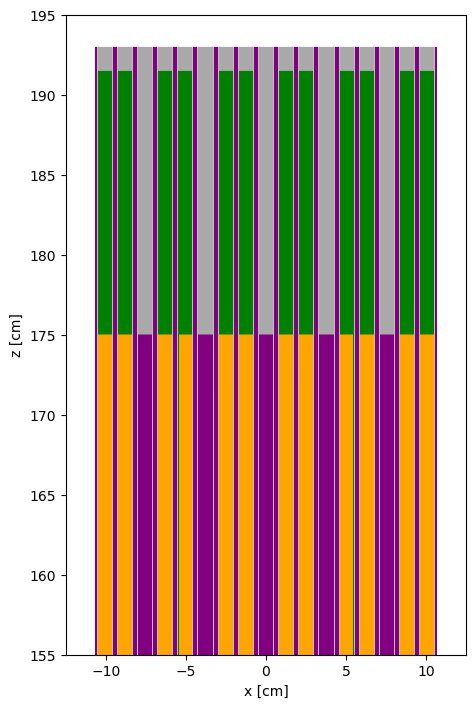

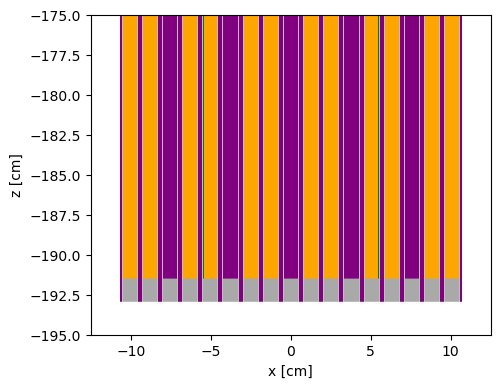

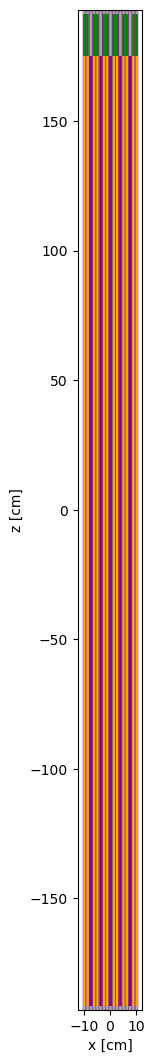

In [9]:
#let's define the parameters for the construction of the assembly (squared 17*17)

###The Bundle###

bundle_pitch=17*rod_pitch

outer_boundary = openmc.model.RectangularPrism(bundle_pitch, 
                                               bundle_pitch, boundary_type='reflective')

#bundle lattice
bundle_lattice= openmc.RectLattice(name='Fuel Assembly')
bundle_lattice.pitch = (rod_pitch, rod_pitch)
bundle_lattice.lower_left = (-bundle_pitch/2, -bundle_pitch/2)

bundle_lattice.universes = np.full((17, 17), fuel_rod_universe)
bundle_lattice.universes[guide_tubes_pos[:, 0], guide_tubes_pos[:, 1]] =guide_tubes

bundle_cell = openmc.Cell(fill=bundle_lattice, region= -outer_boundary & -s_top & +s_bottom)

bundle_universe= openmc.Universe (cells= [bundle_cell])

bundle_universe.plot(basis='xz',width=(25,40), pixels=(400,800), color_by="material",colors=  material_colors,origin =[0,0,175])
bundle_universe.plot(basis='xz',width=(25,20), pixels=(400,800), color_by="material",colors=  material_colors,origin =[0,0,-185])
bundle_universe.plot(basis='xz',width=(25,frod_height), pixels=(500,1000), color_by="material",colors=  material_colors,origin =[0,0,0])
#bundle_universe.plot(basis='xy',width=(2*rod_pitch,2*rod_pitch), pixels=(800,800), color_by="material",colors= material_colors,origin =[0,0,0])
#bundle_universe.plot(basis='xy',width=(24,24), pixels=(800,800), color_by="material",colors= material_colors,origin =[0,0,0])

### import the geometry in a xml file

fuel_cell_geom=openmc.Geometry(bundle_universe)
fuel_cell_geom.export_to_xml()


In [8]:
#let's define the "filters"
#in the parentesis we have the energy groups in Ev (0-->0.68; 0.68-->20*10^6)
#energies = np.logspace(np.log10(1e-5), np.log10(20.0e6), 201)
#energy_filter=openmc.EnergyFilter(energies, filter_id=1)

###Tallies###
'''
#energy_filter=openmc.EnergyFilter([.0,.68,20e6])# Definisci l'intervallo energetico (da 1e-5 eV a 20 MeV)
energy_bounds = np.logspace(np.log10(1e-8), np.log10(30e6), 100)

# Aggiungi manualmente lo zero all'inizio, se necessario
energy_bounds = np.insert(energy_bounds, 0, 0.0)

# Crea l'EnergyFilter
energy_filter = openmc.EnergyFilter(energy_bounds)
msh_filter=openmc.RegularMesh(mesh_id=1)
msh_filter.dimension=(17,17,1)
'''
energy_filter=openmc.EnergyFilter([.0,.68,20e6])
msh_filter=openmc.RegularMesh(mesh_id=1)
msh_filter.dimension=(17,17,1)

# define the most negative and positive cprner creating a parallelepide that contains everything
msh_filter.lower_left= [-bundle_pitch/2, -bundle_pitch/2,-frod_height/2]
msh_filter.upper_right= [bundle_pitch/2, bundle_pitch/2,frod_height/2]
mesh_filter= openmc.MeshFilter(msh_filter,filter_id=2)

flux= openmc.Tally(tally_id=1,name= 'Flux')
flux.scores= ['flux'] #total flux
flux.filters= [energy_filter, mesh_filter]

#define tally for fission power
depos_energy = openmc.Tally(tally_id=2,name='Fission_power')
depos_energy.scores = ['kappa-fission']  # tracks energy deposition per fission   
depos_energy.filters = [mesh_filter] 

fission_rr =openmc.Tally (tally_id=3,name='Fission_reaction_rate')
fission_rr.scores = ['fission']  #total fission reaction rate
fission_rr.filters = [energy_filter, mesh_filter]


tallies = openmc.Tallies([flux,depos_energy,fission_rr])
tallies.export_to_xml()

#!cat.tallies.xml

In [9]:

###Simulation Settings###

#this represents where the first gen of neutrons will appear
source_region= openmc.stats.Box((-bundle_pitch/2,-bundle_pitch/2,-1.),
                                    (bundle_pitch/2,bundle_pitch/2,1.))
source_energy= openmc.stats.Watt( a=988000.0,b=2.249e-06)
source=openmc.IndependentSource(space=source_region,energy=source_energy,
                                    constraints={"fissionable":True})


sim_settings= openmc.Settings()
sim_settings.run_mode='eigenvalue'
sim_settings.particles =100000
sim_settings.inactive=20
sim_settings.batches=100
sim_settings.source= source

# export the simulation settings in te xml file
sim_settings.export_to_xml()

#!cat settings.xml

for cell in fuel_cell_geom.get_all_cells().values():
    print(f"Cell ID: {cell.id}, Region: {cell.region}")

#the output provide a dictionary with the list of different cell that are used to create the 
#universe (in this case fuel_rod_universe). The numbers inside parenthesis rappresents the surfaces
#that composed each cell, with negative and positive def based on what you did in the definition 
#of each regio


Cell ID: 13, Region: (13 -14 15 -16 -4 5)
Cell ID: 1, Region: (8 -6 -1)
Cell ID: 2, Region: (1 8 -6 -2)
Cell ID: 3, Region: (6 -7 -2)
Cell ID: 4, Region: (2 5 -4 -3)
Cell ID: 5, Region: (5 -4 3 9 -10 11 -12)
Cell ID: 7, Region: (7 -4 -2)
Cell ID: 6, Region: (-8 5 -2)
Cell ID: 8, Region: (-2 -6 8)
Cell ID: 12, Region: (-8 5 -2)
Cell ID: 9, Region: (6 -4 -2)
Cell ID: 11, Region: (2 5 -4 -3)
Cell ID: 10, Region: (5 -4 3 9 -10 11 -12)


 Deleted: summary_75.h5
 Deleted: summary.h5
 Deleted: summary_87.h5
 Deleted: summary_62.h5
 Deleted: summary_100.h5

 Running batch optimization for Inactive batches: 40%, Particles: 10^5 ...
mv: cannot stat 'summary.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     

NameError: name 'FormatStrFormatter' is not defined

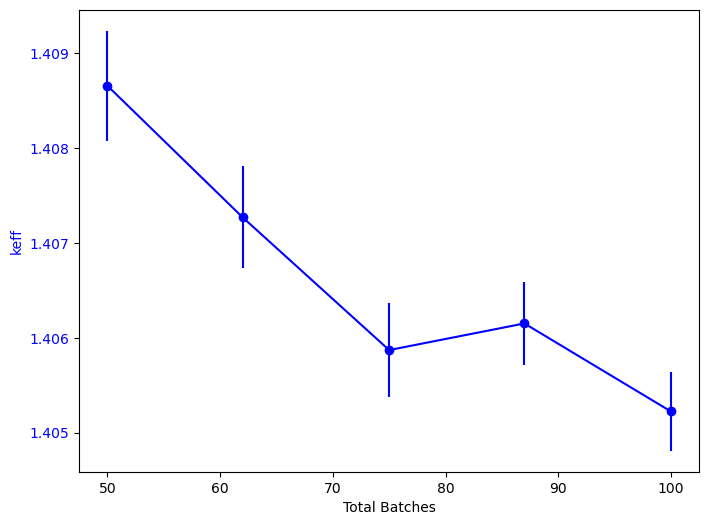

In [12]:
#run the simulation
import time

'''
    - name (str): A label for the case to differentiate runs.
    - N (int): Number of test cases (batch values).
    - batch_range (tuple): (min_batches, max_batches) to test.
    - inactive (int), the percentage of inactive batches
    - source, the one that i defined in the simulation settings cell.
    - particles (int): Number of particles per batch.
'''
###Sensitivity analysis###
start_time = time.time()

name="Inactive batches: 40%, Particles: 10^5 "
N=5
batch_range=(50,100)
particles=100000
inactive=40
source=openmc.IndependentSource(space=source_region,energy=source_energy,
                                    constraints={"fissionable":True})
optimize_batches(name, N, batch_range, inactive, source, particles)

end_time = time.time()  # Record end timestart_time = time.time()  # Record start time
elapsed_time = end_time - start_time  # Compute elapsed time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

#cleaner()
#openmc.run()

In [ ]:
##### How to verify that the sources are working, use of the h5 file
import glob
'''
#function to search for the right statepoint file
def get_latest_statepoint():
    files = sorted(glob.glob("statepoint.*.h5"))
    return files[-1] if files else None  # Return None if no file exists

latest_file = get_latest_statepoint()
if latest_file:
    sp_file = openmc.StatePoint(latest_file)
    print(f"Using statepoint: {latest_file}")
else:
    print("No statepoint file found!")

#sp_file=openmc.StatePoint("statepoint.100.h5") #to be changed every time you re-run the code
plt.quiver(sp_file.source["r"]["x"],sp_file.source["r"]["y"],sp_file.source["u"]["x"],sp_file.source["u"]["y"],
           np.log(sp_file.source["E"]),cmap="jet",scale=15.)#help to visualize the population and directions from the source 
 
#plt.colorbar()
plt.ylim(-bundle_pitch/2, bundle_pitch/2)
plt.xlim(-bundle_pitch/2, bundle_pitch/2)

flux_tally = sp_file.get_tally(scores=['fission'], name='fission_rate') #instead you can do the same for the flux
flux_data=flux_tally.get_reshaped_data()

print(flux_tally.shape,flux_data.shape)
plt.imshow(flux_data[:, :, 0], extent=[-bundle_pitch/2, bundle_pitch/2, -bundle_pitch/2, bundle_pitch/2], origin='lower', cmap='inferno')
plt.colorbar(label='Neutron Flux')
plt.xlabel('X Position (cm)')
plt.ylabel('Y Position (cm)')
plt.title('Neutron Flux in X-Y Plane at Z = 10 cm')
#plt.show()
#K_eff plot
#plt.plot(sp_file.k_generation)

###tally extraction:sp_file.get_tally(scores=["fission"],name=fission_rr) you need the name of the tally
#divide for each energy groups: use the energy filter "get_slicer function", use print(.shape to see the dimensions of the arrays)
#reshape the array of the sliced array(the square of the original mesh) using the function "mean.shape =(25,25)"
#fr_tally = sp_file.get_tally(scores=['fission'], name='Fission reaction rate') #instead you can do the same for the flux
'''

sp_file = openmc.StatePoint("statepoint.100.h5")
fr_tally = sp_file.get_tally(scores=['flux'], name='Flux') #instead you can do the same for the flux
fr1 = fr_tally.get_slice(filters=[openmc.EnergyFilter], filter_bins=[((0., 0.68),)])
fr2 = fr_tally.get_slice(filters=[openmc.EnergyFilter], filter_bins=[((0.68, 20e6),)])
# Correcting the shape mismatch
#fr1.mean = fr1.mean.sum(axis=-1).reshape(25, 25)  # Summing over z bins
#fr2.mean = fr2.mean.sum(axis=-1).reshape(25, 25)
fr1.mean.shape =(17,17)
fr2.mean.shape =(17,17) #(.error)

plt.rcParams['figure.figsize'] = [14, 10]
fig = plt.subplot(121)
fig1 = plt.imshow(fr1.mean, label="E < 1 keV")
fig2 = plt.subplot(122)
fig2.imshow(fr2.mean, label="E > 800 keV")

'''

energy_bins = [0.0, 0.68, 20e6]  # Match the bins used in EnergyFilter
energy_midpoints = [(energy_bins[i] + energy_bins[i+1]) / 2 for i in range(len(energy_bins)-1)]

# Extract flux values
flux_vals = fr_tally.get_values()  # This is a 3D array: (energy, x, y, z)
flux_spectrum = flux_vals.sum(axis=(1,2,3))  # Sum over spatial bins
print(flux_vals.shape)
# Plot the flux spectrum
plt.figure()
plt.bar(energy_midpoints, flux_spectrum, width=np.diff(energy_bins), align='center', alpha=0.7)
plt.xscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Flux')
plt.title('Flux Spectrum')
plt.grid(True)
plt.show()

'#flux spectrum 
# Extract flux spectrum data
flux_tally = sp_file.get_tally(name='Flux')
energy_filter = flux_tally.find_filter(openmc.EnergyFilter)
energy_bins = energy_filter.bins  # Lower bin edges
energy_midpoints = 0.5 * (energy_bins[:-1] + energy_bins[1:])
flux_values = flux_tally.mean.flatten()
energy_bins = energy_filter.bins.flatten()
flux_values = flux_tally.get_values().flatten()  # Get 1D array
#print(f"Energy bins shape: {energy_bins.shape}")
#print(f"Flux values shape: {flux_values.shape}")
energy_bins = energy_filter.bins.flatten()  # Convert to 1D array
energy_midpoints = 0.5 * (energy_bins[:-1] + energy_bins[1:])  # Compute midpoints

# Reshape flux: (num_spatial_bins, num_energy_groups)
num_energy_groups = len(energy_midpoints)
num_spatial_bins = flux_values.size // num_energy_groups
num_energy_groups = len(energy_bins) - 1  # Number of energy groups
num_spatial_bins = flux_values.size // num_energy_groups  # Compute spatial bins

print(f"Total flux values: {flux_values.size}")
print(f"Number of energy groups: {num_energy_groups}")
print(f"Computed number of spatial bins: {num_spatial_bins}")
# Trim extra values if needed
valid_size = num_spatial_bins * num_energy_groups
flux_values = flux_values[:valid_size]  # Keep only the valid part

# Reshape into (spatial_bins, energy_groups)
flux_values = flux_values.reshape((num_spatial_bins, num_energy_groups))

# Average over spatial bins to get the flux spectrum
flux_spectrum = flux_values.mean(axis=0)

# Compute energy midpoints for plotting
energy_midpoints = 0.5 * (energy_bins[:-1] + energy_bins[1:])

flux_values = flux_values.reshape((num_spatial_bins, num_energy_groups))

# Average over spatial bins to get energy-dependent flux
flux_spectrum = flux_values.mean(axis=0)
# Plot flux spectrum
plt.figure(figsize=(8,6))
plt.loglog(energy_midpoints, flux_spectrum, drawstyle='steps-post')
plt.xlabel('Energy (eV)')
plt.ylabel('Flux')
plt.title('Flux Spectrum')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
'''


In [ ]:
#evaluate the ppf

ppf_tally = sp_file.get_tally(id=2)
fission_power = ppf_tally.get_values()

# Compute power peaking factor
max_power = fission_power.max()
#avg_power = fission_power.mean()
avg_power = fission_power.sum()/264 #to avoid the counting of the guide tubes

ppf = max_power / avg_power
print(fission_power.shape)
print(f'Power Peaking Factor: {ppf:.3f}')
print(f'MAx_power: {max_power:.3f}')

In [ ]:
#flux vs location
flux_tally=sp_file.get_tally(id=1)
flux_values = flux_tally.get_values().flatten()  # collapses the multidim array inro one dimension
print("Flux values tally dimension:",flux_values.shape) # as you can see the tally is redefined as a one dim array
thermal_flux_values = flux_values[:289]
print(thermal_flux_values)
# export the mesh
mesh_filter =flux_tally.find_filter(openmc.MeshFilter)
mesh = mesh_filter.mesh 
print("Mesh tally:",type(mesh)) #is a  class: 'openmc.mesh.RegularMesh' 

# the coordinates for the mesh
x_vals = np.linspace(mesh.lower_left[0], mesh.upper_right[0], mesh.dimension[0])
y_vals = np.linspace(mesh.lower_left[1], mesh.upper_right[1], mesh.dimension[1])
print("Len of the coordinates array along x/y",len(x_vals)) #x and y are arrays defined as (starting value, final value, number of subintervals)
print("Values inside the arrays",x_vals) # the coordinates are thus defined as (-bundle_pitch/2,bundle_pitch/2, 17)

# Reshape flux data to match mesh grid, passes from 289->17x17
flux_grid = thermal_flux_values.reshape(mesh.dimension[0], mesh.dimension[1])
print("Flux reshaped in the grid",flux_grid.shape)

# Choose a middle row to analyze
mid_row = (mesh.dimension[1] // 2)+1  # fix a y coordinate 

plt.figure(figsize=(8, 5))
plt.bar(x_vals, flux_grid[mid_row, :], width=0.5, color='blue', alpha=0.7, label="Flux")
#for that fixed coordinate it's possible to plot all the possible values along x ([mid_row,:])
print("Flux values along mid_row:",flux_grid[mid_row, :])
plt.xlabel("x [cm]")
plt.ylabel("Thermal flux[(eV*cm)^-1]")
plt.title("Flux Profile along x fixed y")
plt.legend()
plt.ylim(0.,0.02)
plt.grid(True)

# Choose a middle column
mid_col = (mesh.dimension[0] // 2)+1  # Middle column

plt.figure(figsize=(8, 5))
plt.bar(y_vals, flux_grid[:, mid_col], width=0.5, color='red', alpha=0.7, label="Flux")
plt.xlabel("Y Coordinate [cm]")
plt.ylabel("Flux ")
plt.title("Flux Profile along y fixed x")
plt.ylim(0.,0.02)
plt.legend()
plt.grid(True)

#Plotting the peaking factors and power distribution maps
#creating the list of power peak per each coordinates
#power vs location, already imported in fission_power 
fission_power.flatten()  # collapses the multidim array inro one dimension

# export the mesh
mesh_filter =ppf_tally.find_filter(openmc.MeshFilter)
mesh = mesh_filter.mesh 
print("Mesh tally:",type(mesh)) #is a  class: 'openmc.mesh.RegularMesh' 

# the coordinates for the mesh
x_vals = np.linspace(mesh.lower_left[0], mesh.upper_right[0], mesh.dimension[0])
y_vals = np.linspace(mesh.lower_left[1], mesh.upper_right[1], mesh.dimension[1])
print("Len of the coordinates array along x/y",len(x_vals)) #x and y are arrays defined as (starting value, final value, number of subintervals)
print("Values inside the arrays",x_vals) # the coordinates are thus defined as (-bundle_pitch/2,bundle_pitch/2, 17)

# Reshape flux data to match mesh grid, passes from 289->17x17
power_grid = fission_power.reshape(mesh.dimension[0], mesh.dimension[1])
print("Flux reshaped in the grid",power_grid.shape)


ppf_grid = power_grid / avg_power 
ppf_list = []
for i in range(mesh.dimension[0]):
    for j in range(mesh.dimension[1]):
        
        if not any((guide_tubes_pos == [i, j]).all(axis=1)):
            ppf_value = ppf_grid[i, j]
            x_coord = x_vals[i]
            y_coord = y_vals[j]
            ppf_list.append((ppf_value, (x_coord, y_coord)))

# Sort list by highest PPF value (descending order)
ppf_list.sort( key=lambda x: x[0])#,reverse=True)

# Print top regions with highest PPF
for i in range(10):  # Show top 10 high-power locations
    print(f"PPF = {ppf_list[i][0]:.3f} at (X={ppf_list[i][1][0]:.2f}, Y={ppf_list[i][1][1]:.2f})")
#print(ppf_list)

fig, ax = plt.subplots(figsize=(10, 8))  

# Choose an improved colormap
cmap = "RdBu_r"  # Alternatives: "cividis", "plasma", "viridis"

vmin=np.min(ppf_grid)
vmax=np.max(ppf_grid)
# Plot the heatmap
img = ax.imshow(ppf_grid, cmap=cmap, origin="lower",
                extent=[mesh.lower_left[0], mesh.upper_right[0],
                        mesh.lower_left[1], mesh.upper_right[1]])

# Add colorbar with better positioning
cbar = plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Power Factor ", fontsize=12)

# Compute proper text positions
x_centers = np.linspace(mesh.lower_left[0], mesh.upper_right[0], mesh.dimension[0], endpoint=False) + (mesh.upper_right[0] - mesh.lower_left[0]) / (2 * mesh.dimension[0])
y_centers = np.linspace(mesh.lower_left[1], mesh.upper_right[1], mesh.dimension[1], endpoint=False) + (mesh.upper_right[1] - mesh.lower_left[1]) / (2 * mesh.dimension[1])

# Annotate PPF values inside each cell
for i in range(mesh.dimension[0]):
    for j in range(mesh.dimension[1]):
        if any((guide_tubes_pos == [i, j]).all(axis=1)):  
            continue  # Skip guide tube locations
        ax.text(x_centers[i], y_centers[j], f"{ppf_grid[j, i]:.3f}",  # Swap indices if needed
                ha='center', va='center', fontsize=8, 
                color="black" if ppf_grid[j, i] < 1.0 else "white")  # Adaptive text color

# Overlay guide tube positions
if 'guide_tubes_pos' in locals():
    gt_x = x_centers[guide_tubes_pos[:, 0]]
    gt_y = y_centers[guide_tubes_pos[:, 1]]
    ax.scatter(gt_x, gt_y, color="cyan", s=80, label="Guide Tube")

# Labels and title
ax.set_xlabel("x [cm]", fontsize=12)
ax.set_ylabel("y [cm]", fontsize=12)
ax.set_title("Power distribution map", fontsize=14, fontweight='bold')

plt.show()



In [ ]:
'''
sp = openmc.StatePoint(f"statepoint.20.h5")
print(sp.k_combined.std_dev)
keffs=[]
keff_stddev
keff_stddev =sp.keff.std_dev#= sp.k_combined.std_dev    # Mean and standard deviation of keff
        # Compute relative error
print(keff_stddev)
keffs=sp.keff.nominal_value
print(keff_stddev/keffs)

list1 = [10, 20, 30, 40]  
list2 = [2, 4, 6, 8]  

# Compute element-wise ratio
ratio_list = [a / b for a, b in zip(list1, list2)]

# Print the result
print(ratio_list)

keff_mean = sp.k_combined 
print(keff_mean)
keff_stddev = sp.keff.std_dev    # Mean and standard deviation of keff
        # Compute relative error
print(keff_stddev)
rel_error = keff_stddev / keffs

        # Store values


# Print results
print(rel_error
'''